We will walkthrough a more complex form of time-series forecasting, which is LSTM. In this notebook, I build the LSTM model for predicting the FPT's stock price

Our goal in this project is to make the model smarter, as the Linear Regression one just use the data from the previous day to predict the next. We need to get rid of that first.

# 1. Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error


# 2. Getting the Data / Preprocess


We use the build-in library which is the `vnstock` API from SSI

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from vnstock import Quote


symbol = 'MBB'
start_date = '2019-01-01'
end_date = '2026-01-14'


quote = Quote(symbol=symbol, source='VCI')

df = quote.history(start=start_date, end=end_date, interval='1D')

Version Vnai 2.3.0 is available. Please update using: `pip install vnai --upgrade`.
Release history: https://pypi.org/project/vnai/#history
Current version: 2.2.6

In [3]:
df.shape

(1839, 6)

In [4]:
df.isna().sum()

time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

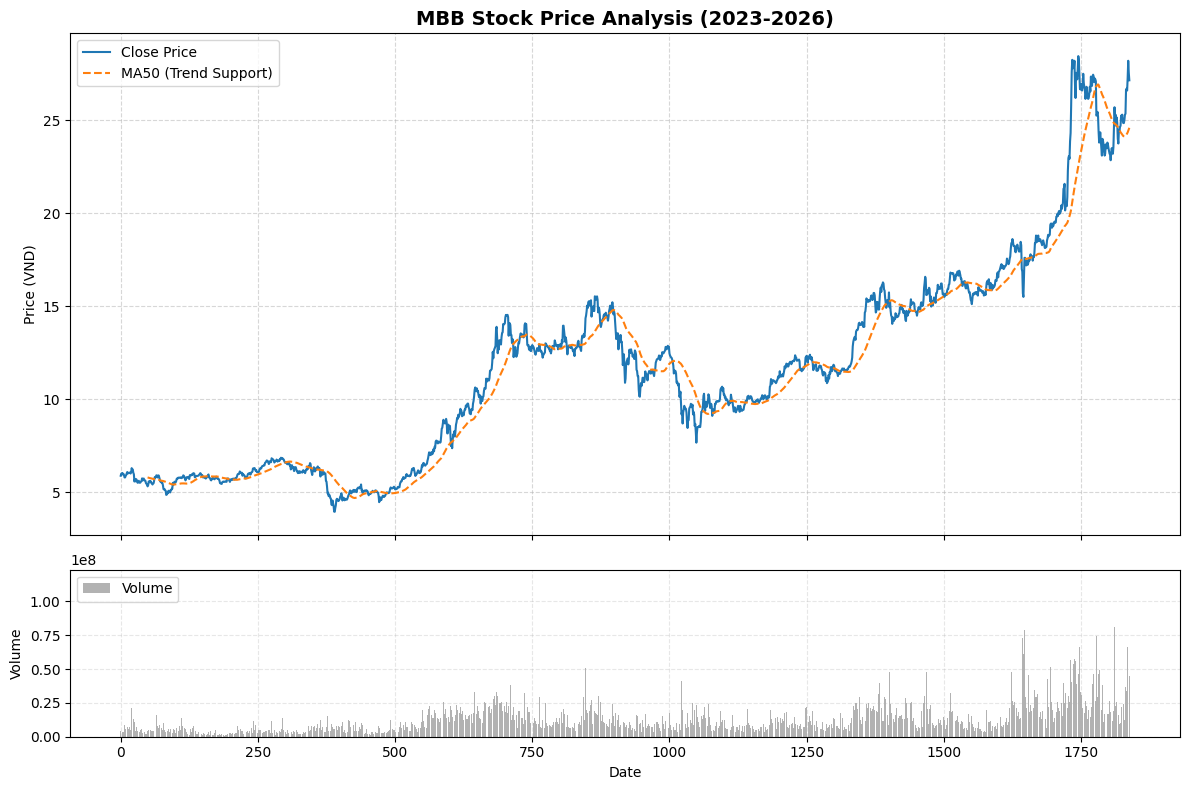

In [5]:
df['MA50'] = df['close'].rolling(window=50).mean()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# --- Top Chart: Price & MA ---
ax1.set_title('MBB Stock Price Analysis (2023-2026)', fontsize=14, fontweight='bold')
ax1.plot(df.index, df['close'], label='Close Price', color='#1f77b4', linewidth=1.5)
ax1.plot(df.index, df['MA50'], label='MA50 (Trend Support)', color='#ff7f0e', linestyle='--', linewidth=1.5)
ax1.set_ylabel('Price (VND)')
ax1.legend(loc='upper left')
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# --- Bottom Chart: Volume ---
ax2.bar(df.index, df['volume'], label='Volume', color='gray', alpha=0.6)
ax2.set_ylabel('Volume')
ax2.set_xlabel('Date')
ax2.legend(loc='upper left')
ax2.grid(True, which='both', linestyle='--', alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In order to put our data in the model, we need to preprocess it

Just to remind, this is the thing that we need to predict, the close price:

<Axes: >

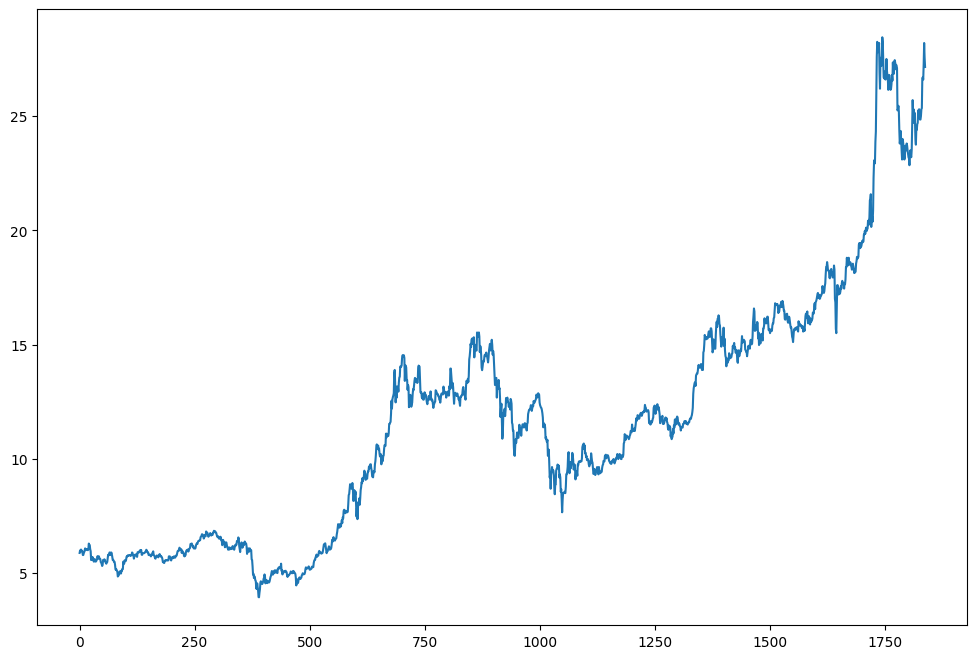

In [6]:
df.close.plot(figsize=(12,8))

The target column is now transformed into data with mean 0 and std 1

Now this is the fun part, we will use a kind of sliding window to get the data for the model. This is widely seen in preprocessing TimeSeries data, and actually if you're sneakpeeking into the LLMs, then it's an usual practice too. They're all **Autoregressive** models if you know it.

In [7]:
feature_columns = ['open', 'high', 'low', 'close', 'volume']
data = df[feature_columns].values

In [8]:
data.shape

(1839, 5)

In [9]:
np.isnan(data).sum()

np.int64(0)

In [ ]:
def create_multivariate_window(data, n_steps, target_col_idx):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Input (X): All columns for the past 'n_steps' days
        X.append(data[i : i + n_steps, :]) 
        
        # Target (y): Only the 'close' price for the next day
        y.append(data[i + n_steps, target_col_idx])
        
    return np.array(X), np.array(y)

n_steps = 60
# feature_columns = ['open', 'high', 'low', 'close', 'volume', 'MA50']
target_col_idx = 3

X, y = create_multivariate_window(data, n_steps, target_col_idx)


In [13]:
print(f"Input Shape (X): {X.shape}") 
# Expected: (Samples, 60, 6) -> 6 is the number of features
print(f"Target Shape (y): {y.shape}")

Input Shape (X): (1779, 60, 5)
Target Shape (y): (1779,)


In [14]:
split_ratio = 0.8

split_index = int(len(X) * split_ratio)

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1423, 60, 5)
y_train shape: (1423,)
X_test shape: (356, 60, 5)
y_test shape: (356,)


Another detail here is that we're feeding these data into a model in Pytorch, so we have to convert our date to Tensor, using the DataLoader from torch.utils

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
# Fit on the raw 2D data before windowing

scaled_X_data = scaler.fit_transform(data)
target_data = data[:, 3].reshape(-1, 1) # Index 3 is 'close'
scaled_y_data = y_scaler.fit_transform(target_data)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
X_train_t = torch.Tensor(scaled_X_data)

y_train_t = torch.Tensor(scaled_y_data).view(-1, 1) # Reshape our y to (1423,1)

train_data = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

So now we're good to train the model !

# 3. Build the model

It's kinda convenient to have the 'LSTM' module in Pytorch, so we don't have to implement things all from scratch

Our model will consist of two parts:
- LSTM layers, followed by a Dropout layer
- Fully connected layer at the end

In [16]:
class StockLSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim, num_layers, output_dim):
        super(StockLSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
    # We train the data in batches, so we set batch_first = True
        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers, batch_first= True,dropout=0.2)

        self.fc = nn.Linear(hidden_dim,output_dim)

    def forward(self,x):
        # Initialize the hidden state and the cell state
        h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).to(x.device)
        
        out, (hn,cn) = self.lstm(x, (h0,c0))
        
        # We only care about the last time step
        out = self.fc(out[:,-1,:])
        return out

In [22]:
model = StockLSTM(input_dim=5, hidden_dim=64, num_layers=2, output_dim=1)

# 4. Train the model

We'll use Huberloss, and Adam optimizer. 

In [18]:
import numpy as np
print(f"Any NaNs in X_train: {np.isnan(X_train).any()}")
print(f"Any NaNs in y_train: {np.isnan(y_train).any()}")

Any NaNs in X_train: False
Any NaNs in y_train: False


In [19]:
criterion = nn.HuberLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [23]:
num_epochs = 50

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        if torch.isnan(loss):
            print(f"NaN detected at Epoch {epoch+1}, Batch {i}. Check your input scaling!")
            break
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/50], Loss: 0.041950
Epoch [20/50], Loss: 0.038834
Epoch [30/50], Loss: 0.028391
Epoch [40/50], Loss: 0.023728
Epoch [50/50], Loss: 0.020795


# 5.Evaluate the model

In [24]:
model.eval()

StockLSTM(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [25]:
with torch.no_grad():
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    predictions = model(X_test_t)

Inverse transform the prediction

In [ ]:
predictions_np = predictions.numpy()

y_test_real = y_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_real = y_scaler.inverse_transform(predictions_np)

ValueError: non-broadcastable output operand with shape (356,1) doesn't match the broadcast shape (356,5)